### Flowchart to illustrate the computation of the coherence metric

In [1]:
import numpy              as np 
import matplotlib.pyplot  as plt 
import matplotlib.patches as patches
import os

# Import xfrites with methods for time-frequency analysis and coherence estimation
from xfrites.conn.conn_coh import  _create_kernel, _smooth_spectra,\
                                   _tf_decomp, conn_coherence_wav

In [2]:
# Create directory to save figures
if not os.path.exists("img/n3.0.5"):
    os.makedirs("img/n3.0.5")

#### Define class to create dummy data

In [3]:
class coupled_wn():
    
    def __init__(self, n_trials=1, n=1000, cov=None):
        # Number of samples of the process
        assert isinstance(n,int)
        # Number of trials of the process
        assert isinstance(n_trials,int)
        self.n        = n
        self.n_trials = n_trials
        # If no covariance matrix is not provided instantiate uncoupled gaussian processes
        if not isinstance(cov,np.ndarray):
            self.cov = np.array([[1,0],[0,1]])
        else:
            assert cov.ndim>=2 and (cov.shape[0]==cov.shape[1])
            self.cov = cov
    
    def get_data(self, seed=0):
        # Create data
        data = np.random.multivariate_normal(np.zeros(self.cov.shape[0]), self.cov, size=(self.n_trials,self.n))
        # Swap axis to order (n_trials, n_processes, n_times)
        return np.swapaxes(data, 1,2)

### Time-frequency decomposition

In [4]:
# Number of trials 
n_trials  = 100
# Number of samples
n_samples = 5000
# Sample frequency
fs        = 1000
# Time array
time      = np.linspace(0, n_samples/fs, n_samples)
# Frequencies array 
freqs     = np.linspace(5,100,50)
# Return a 2D covariance matrix with variable cross-correlation
def _return_cov2D(rho=0):
    assert isinstance(rho, (int,float)) and rho<=1
    return np.array([[1,rho],[rho,1]])

In [5]:
data = coupled_wn(n_trials = n_trials,
                  n = n_samples,
                  cov = _return_cov2D(0.5)).get_data()

In [6]:
# Compute wavelet/multitaper coefficients (n_trials, n_processes, n_freqs, n_times)
W = _tf_decomp(data, fs, freqs, mode='morlet', n_cycles=freqs/2, mt_bandwidth=None,
           decim=1, kw_cwt={}, kw_mt={}, n_jobs=-1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    5.0s finished


In [7]:
# Compute auto spectra
Sii = W*np.conj(W)
# Compute Cross spectra
Sij = W[:,0,:,:]*np.conj(W[:,1,:,:])

#### Smoothed spectra

In [8]:
# Creating smoothing kernel
sm_times = 300
sm_freqs = 5
kernel   = _create_kernel(sm_times, sm_freqs, kernel='square')

In [9]:
sSii     = _smooth_spectra(Sii, kernel, decim=1)
sSij     = _smooth_spectra(Sij, kernel, decim=1)

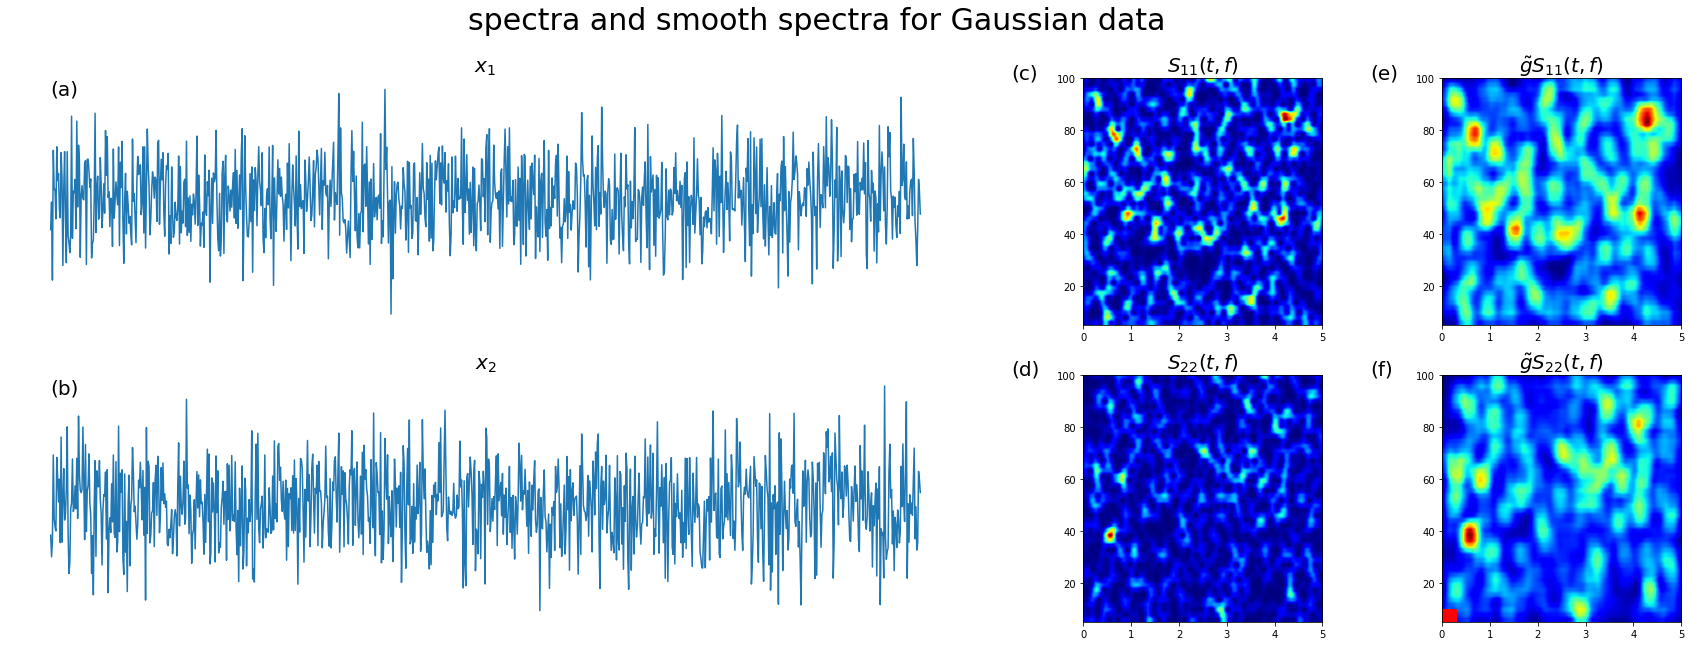

In [10]:
# Plotting spectra
fig = plt.figure(figsize=(30,10))
### PLOTTING DATA ###
plt.subplot2grid((2,5),(0,0),colspan=3)
plt.plot(data[0,0,2000:3000])
plt.title(r'$x_1$', fontsize=20)
plt.axis("off")
plt.text(0,3,"(a)", fontsize=20)
plt.subplot2grid((2,5),(1,0),colspan=3)
plt.plot(data[0,1,2000:3000])
plt.text(0,3,"(b)", fontsize=20)
plt.title(r'$x_2$', fontsize=20)
plt.axis("off")
### PLOTTING SPECTRA ###
plt.subplot2grid((2,5),(0,3),colspan=1)
plt.imshow(Sii.real[0,0],  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
plt.text(-1.5,100,"(c)", fontsize=20)
plt.title(r'$S_{11}(t,f)$', fontsize=20)
plt.subplot2grid((2,5),(0,4),colspan=1)
plt.imshow(sSii.real[0,0], aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
plt.text(-1.5,100,"(e)", fontsize=20)
plt.title(r'$\tilde{g}S_{11}(t,f)$', fontsize=20)
plt.subplot2grid((2,5),(1,3),colspan=1)
plt.imshow(Sii.real[0,1],  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
plt.text(-1.5,100,"(d)", fontsize=20)
plt.title(r'$S_{22}(t,f)$', fontsize=20)
plt.subplot2grid((2,5),(1,4),colspan=1)
plt.imshow(sSii.real[0,1], aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
plt.text(-1.5,100,"(f)", fontsize=20)
rect = patches.Rectangle((time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)
plt.title(r'$\tilde{g}S_{22}(t,f)$', fontsize=20)
plt.suptitle('spectra and smooth spectra for Gaussian data', fontsize=30)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2,wspace=0.5)
plt.savefig("img/n3.0.5/tf_decomp.pdf", dpi=600)

#### **Caption:** Auto-spectra for two coupled gaussian distributed time-series with covariance $\rho=0.5$. In (a,b) we show the first and second time-series respectively for one trial. In (c,d) we show the auto-spectra for each of the time-series prior to the smoothing, and finally in (e,f) we show the same auto-spectra after applying a "boxcar" smoothing kernel with dimensions 0.3ms in time and $w_f$=2Hz in frequency indicated as a red box in (f).

### Computing coherence

In [11]:
# Computing coherence (withoud smoothing)
coh  = (np.abs(Sij[0]) ** 2 / (Sii[0,0] * Sii[0,1])).real
# Computing coherence (with smoothing)
scoh = (np.abs(sSij[0]) ** 2 / (sSii[0,0] * sSii[0,1])).real

<ipython-input-12-2d0bffa38e8c>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2_5 = fig.add_axes([0.1, 0.62, 1.5, 0.1])


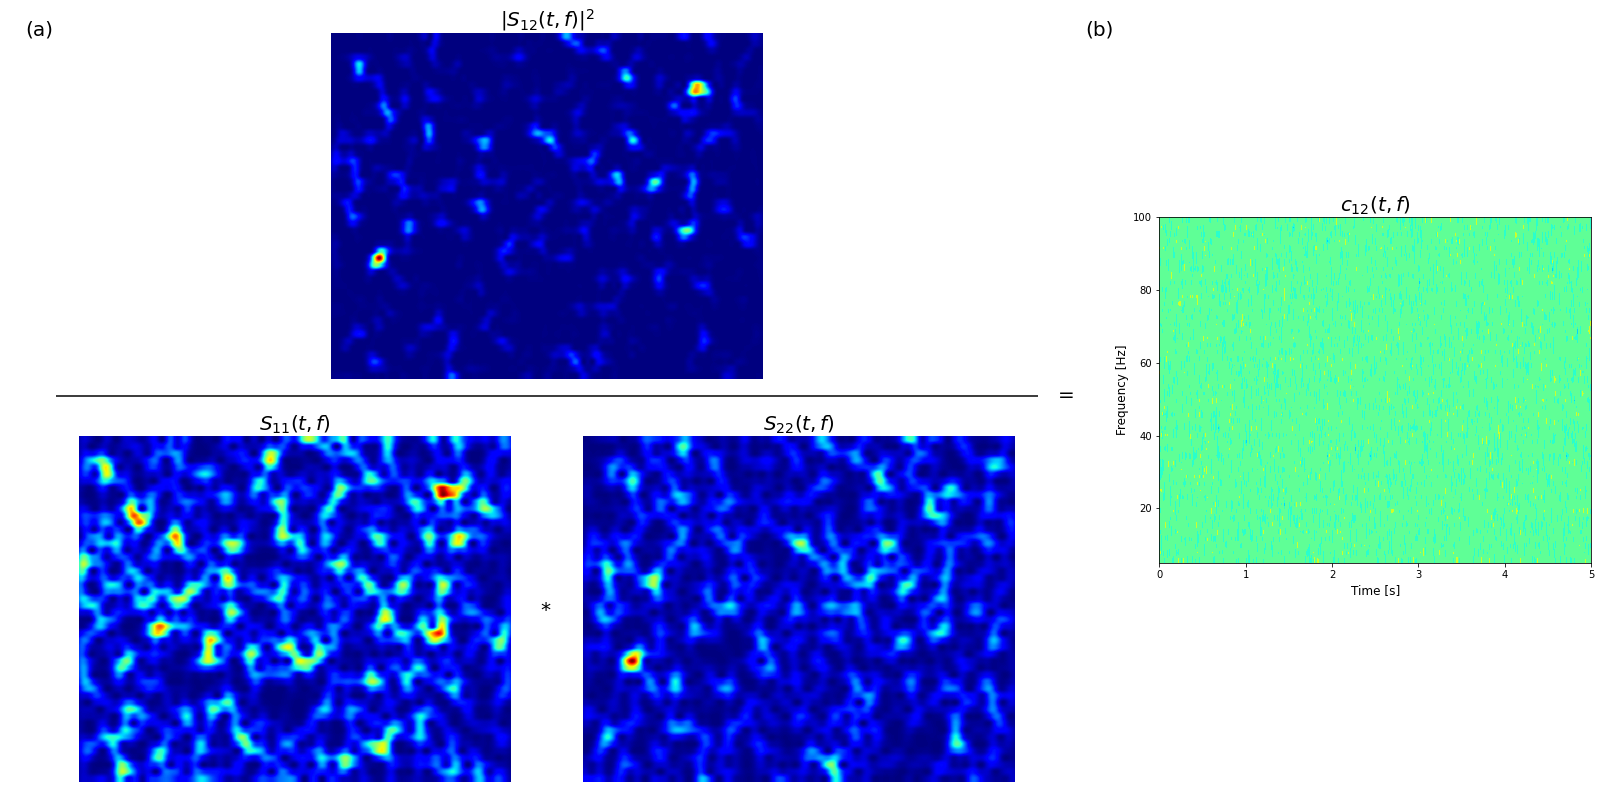

In [12]:
fig = plt.figure(figsize=(10, 8))
# Blanck canvas
ax  = fig.add_subplot(111)
ax.axis("off")
ax.text(0,1.55,"(a)",fontsize=20)
ax.text(1.9,1.55,"(b)",fontsize=20)

### PLOTTING CROSS-SPECTRA ###
ax1 = fig.add_axes([0.55, 0.7, 0.6, 0.6])
ax1.imshow(np.abs(Sij.real[0])**2,  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
ax1.axis("off")
plt.title(r'$|S_{12}(t,f)|^2$', fontsize=20)

### PLOTTING DIVISION MARK
ax1_5 = fig.add_axes([0.1, 0.62, 1.5, 0.1])
ax1_5.hlines(0,0,100, color="k")
ax1_5.axis("off")
ax1_5.text(102, -0.01, "=", size=20)

### PLOTTING AUTO-SPECTRA ###
ax2 = fig.add_axes([0.2, 0, 0.6, 0.6])
ax2.imshow(Sii.real[0,0],  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
ax2.axis("off")
plt.title(r'$S_{11}(t,f)$', fontsize=20)

### PLOTTING MULTIPLICATION MARK
ax2_5 = fig.add_axes([0.1, 0.62, 1.5, 0.1])
ax2_5.text(49.3, -0.42, "*", size=20)
ax2_5.axis("off")

ax3 = fig.add_axes([0.9, 0, 0.6, 0.6])
ax3.imshow(Sii.real[0,1],  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
ax3.axis("off")
plt.title(r'$S_{22}(t,f)$', fontsize=20)

### PLOTTING COHERENCE
ax4 = fig.add_axes([1.7, 0.38, 0.6, 0.6])
ax4.imshow(coh,  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
plt.title(r'$c_{12}(t,f)$', fontsize=20)
plt.ylabel("Frequency [Hz]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
fig.savefig("img/n3.0.5/coh_non_smoothed.pdf", bbox_inches = 'tight',pad_inches=.5, dpi=600)

#### **Caption:** Computation of the coherence for the non-smoothed spectra for the two coupled gaussian distributed time-series with covariance $\rho=0.5$. In (a) we display the non-smoothed cross- (top) and auto-spectra (bottom) used to estimate the coherence (obtained by the ration between the absolute value of the square cross-spectrum by the product of the two auto-spectra). In (b) we show the coherence resulting from the operation with the spectra, since the smoothing operation was not applied the coherence is $1$ for all the time-frequency domain.

<ipython-input-13-cbfddc03755b>:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2_5 = fig.add_axes([0.1, 0.62, 1.5, 0.1])


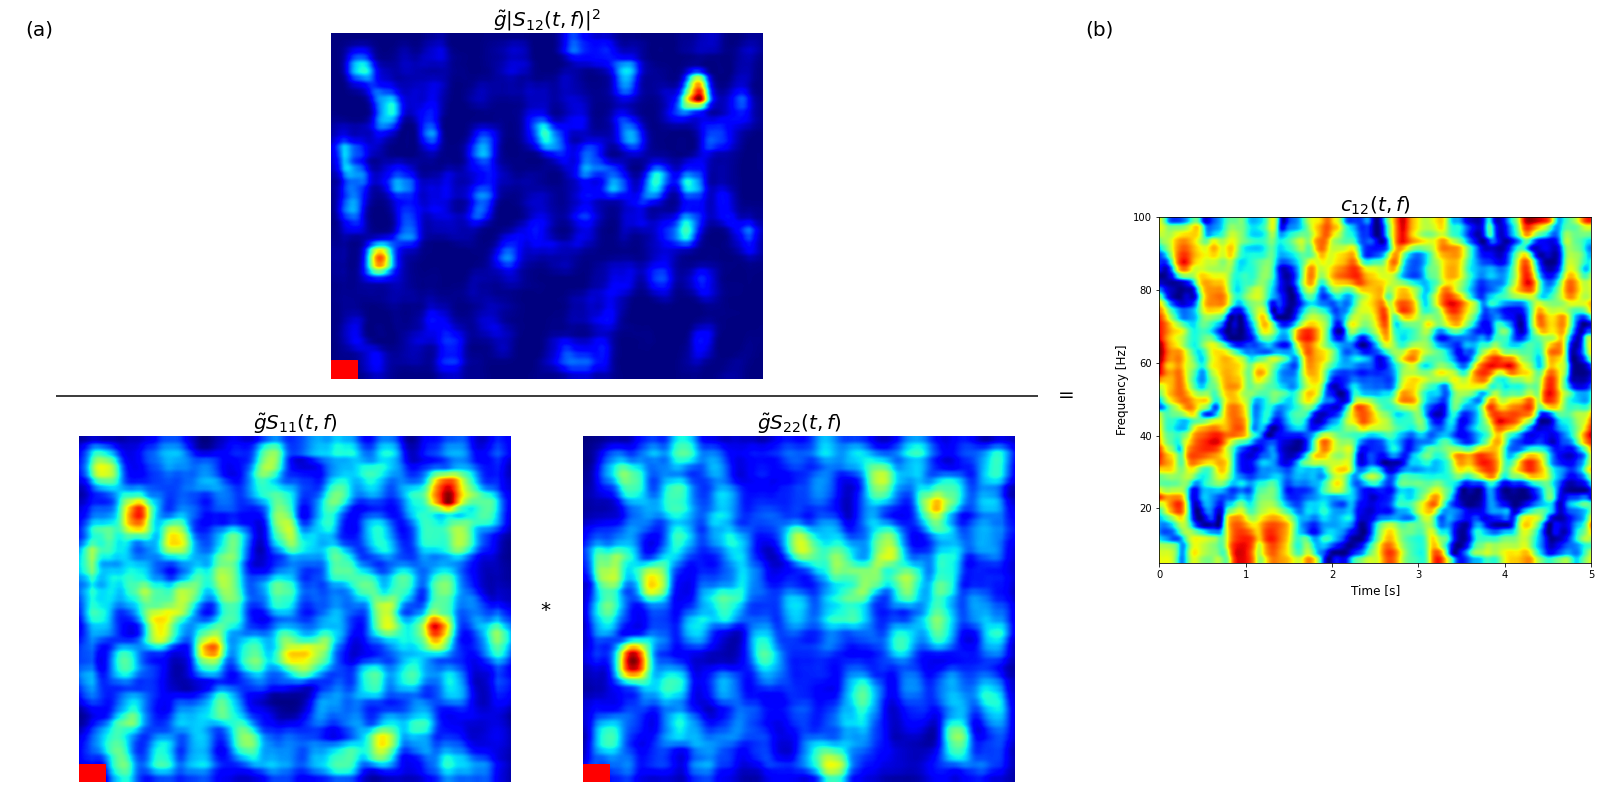

In [13]:
fig = plt.figure(figsize=(10, 8))
# Blanck canvas
ax  = fig.add_subplot(111)
ax.axis("off")
ax.text(0,1.55,"(a)",fontsize=20)
ax.text(1.9,1.55,"(b)",fontsize=20)

### PLOTTING CROSS-SPECTRA ###
ax1 = fig.add_axes([0.55, 0.7, 0.6, 0.6])
ax1.imshow(np.abs(sSij.real[0])**2,  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
ax1.axis("off")
plt.title(r'$\tilde{g}|S_{12}(t,f)|^2$', fontsize=20)
rect = patches.Rectangle((time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)

### PLOTTING DIVISION MARK
ax1_5 = fig.add_axes([0.1, 0.62, 1.5, 0.1])
ax1_5.hlines(0,0,100, color="k")
ax1_5.axis("off")
ax1_5.text(102, -0.01, "=", size=20)

### PLOTTING AUTO-SPECTRA ###
ax2 = fig.add_axes([0.2, 0, 0.6, 0.6])
ax2.imshow(sSii.real[0,0],  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
ax2.axis("off")
plt.title(r'$\tilde{g}S_{11}(t,f)$', fontsize=20)
rect = patches.Rectangle((time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)

### PLOTTING MULTIPLICATION MARK
ax2_5 = fig.add_axes([0.1, 0.62, 1.5, 0.1])
ax2_5.text(49.3, -0.42, "*", size=20)
ax2_5.axis("off")

ax3 = fig.add_axes([0.9, 0, 0.6, 0.6])
ax3.imshow(sSii.real[0,1],  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
ax3.axis("off")
plt.title(r'$\tilde{g}S_{22}(t,f)$', fontsize=20)
rect = patches.Rectangle((time[0],freqs[0]), sm_times/1000, sm_freqs, color='r')
plt.gca().add_patch(rect)

### PLOTTING COHERENCE
ax4 = fig.add_axes([1.7, 0.38, 0.6, 0.6])
ax4.imshow(scoh,  aspect='auto', cmap='jet', origin='lower', extent=[time[0],time[-1],freqs[0],freqs[-1]])
plt.title(r'$c_{12}(t,f)$', fontsize=20)
plt.ylabel("Frequency [Hz]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
fig.savefig("img/n3.0.5/coh_smoothed.pdf", bbox_inches = 'tight',pad_inches=.5, dpi=600)

#### **Caption:** Computation of the coherence for the spectra smoothed with a "boxcar" kernel with dimensions 0.3ms in time and $w_f$=2Hz in frequency for the two coupled gaussian distributed time-series with covariance $\rho=0.5$. In (a) we display the smoothed cross- (top) and auto-spectra (bottom) used to estimate the coherence (obtained by the ration between the absolute value of the square cross-spectrum by the product of the two auto-spectra). In (b) we show the coherence resulting from the operation with the spectra, with the smoothed spectra some patterns could be retrieved.